# CRISP-DM METHODOLOGY - Cross Industry Standard Process for Data Mining

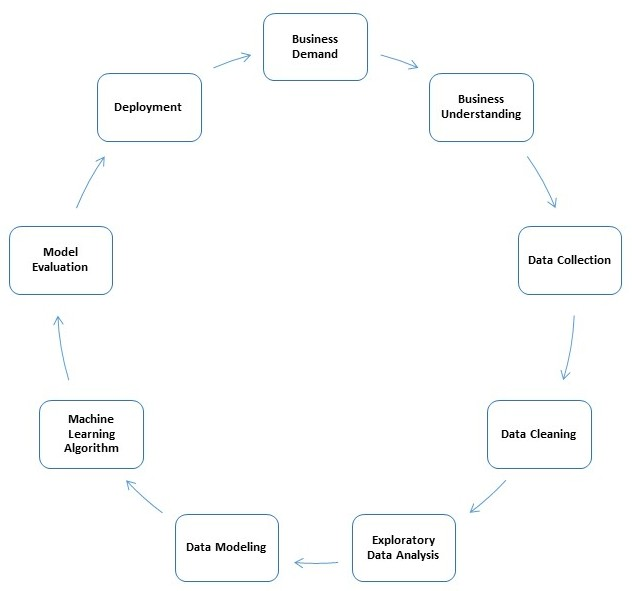

In [423]:
Image("img/crisp1.jpg")

# 0.0 IMPORTS

In [443]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import xgboost as xgb
import random
import warnings
import pickle

from IPython.display          import Image
from scipy                    import stats as ss
from datetime                 import timedelta
from sklearn.preprocessing    import RobustScaler, MinMaxScaler, LabelEncoder
from IPython.core.display     import HTML
from boruta                   import BorutaPy
from sklearn.ensemble         import RandomForestRegressor
from sklearn.metrics          import mean_absolute_error, mean_squared_error
from sklearn.linear_model     import LinearRegression, Lasso

# warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [425]:
def cramer_v(x, y):
    cm = pd.crosstab(x,y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2_corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    k_corr = k - (k-1)**2/(n-1)
    r_corr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2_corr/n) / ( min( k_corr-1, r_corr-1) ) )

def mean_percentage_error(y, yhat):
    return np.mean( ( y-yhat ) / y )

def mean_absolute_percentage_error(y, yhat):
    return np.mean( np.abs( ( y-yhat ) / y ) )

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt(mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name' : model_name,
                           'MAE' : mae,
                           'MAPE' : mape,
                           'RMSE' : rmse }, index=[0] )

def cross_validation(x_training, k_fold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1,k_fold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))

        # start and end date for validation
        validation_start_date = x_training['date'].max()- datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max()- datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training   =  x_training[x_training['date']<validation_start_date]
        validation =  x_training[(x_training['date']>=validation_start_date) & (x_training['date']<=validation_end_date)]
        
        if verbose:
            print('\n\nStart: {}\nEnd: {}\nTotal Treinamento: {}\nTotal Validação: {}'.format(validation_start_date, validation_end_date, len(training.index), len(validation.index) ) )

        # training and validation dataset
        xtraining  = training.drop(['date', 'sales'], axis=1) 
        ytraining =  training['sales']                         

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat) )
        mae_list.append(  m_result['MAE'])
        mape_list.append( m_result['MAPE'])
        rmse_list.append( m_result['RMSE'])
        
    return pd.DataFrame(
                        {
                         'Model Name' : model_name,
                         'MAE' : np.round( np.mean(mae_list), 2 ).astype(str)  + ' +/- ' + np.round( np.std(mae_list), 2 ).astype(str),
                         'MAPE': np.round( np.mean(mape_list), 2 ).astype(str) + ' +/- ' + np.round( np.std(mape_list), 2 ).astype(str),
                         'RMSE': np.round( np.mean(rmse_list), 2 ).astype(str) + ' +/- ' + np.round( np.std(rmse_list), 2 ).astype(str)
                        },
                        index=[0]
                    )

def jupyter_settings():
   %matplotlib inline
   %pylab inline
   plt.style.use( 'bmh' )
   plt.rcParams['figure.figsize'] = [20, 10]
   plt.rcParams['font.size'] = 10
   display( HTML( '<style>.container { width:100% !important; }</style>') )
   pd.options.display.max_columns = None
   pd.options.display.max_rows = None
   pd.set_option( 'display.expand_frame_repr', False )

sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


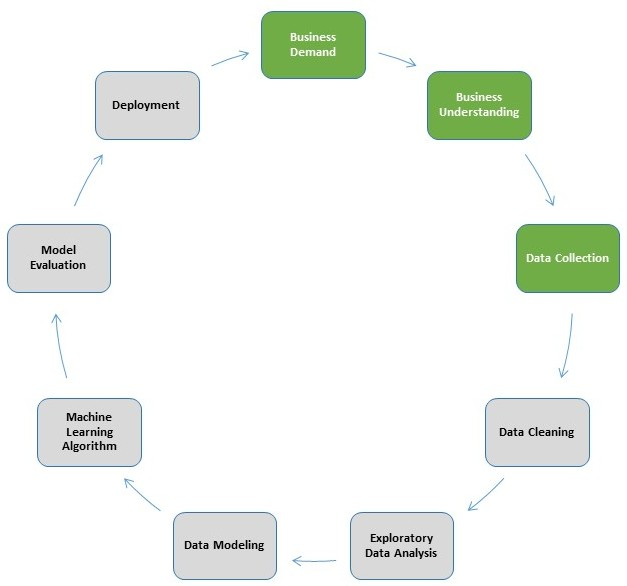

In [426]:
Image("img/crisp2.jpg")

## 0.2 Loading data

In [427]:
df_sales_raw = pd.read_csv('dados/train.csv', low_memory=False)
df_store_raw = pd.read_csv('dados/store.csv', low_memory=False)

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 DATA DESCRIPTION

In [428]:
df1 = df_raw.copy()

In [429]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

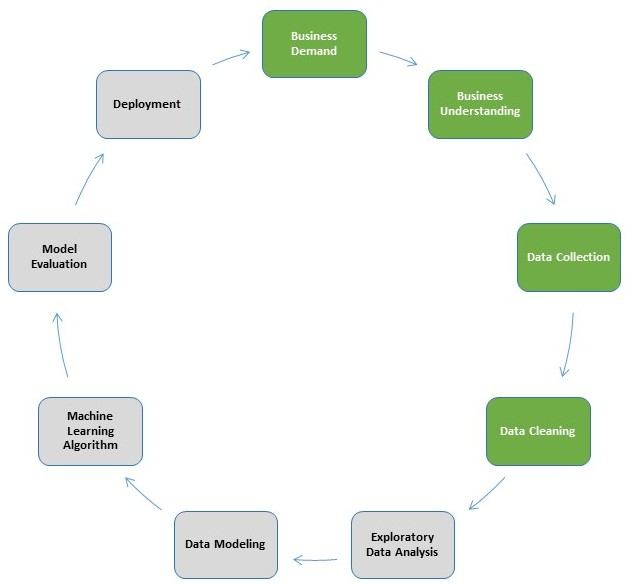

In [430]:
Image("img/crisp3.jpg")

## 1.1 Rename Columns

In [431]:
cols_old = df1.columns.to_list()

# funcao para transformar os nomes de campos de CamelCase para snakecase
snakecase = lambda x: inflection.underscore(x)

cols_new = list( map (snakecase, cols_old) )

#rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [432]:
df1.shape

(1017209, 18)

## 1.3 Data Sample

In [433]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.4 Data Types

In [434]:
# Altera tipo de dados de object para date
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.5 Check NA

In [435]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.6 Fillout NA

In [436]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr',  5:'May',  6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1 )

In [437]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.7 Descriptive Statistical

In [438]:
# criando dataframe por tipo de dados
num_attributes = df1.select_dtypes( exclude=['object', 'datetime64[ns]'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

## 1.7.1 Numerical Attributes

In [439]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kutosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='customers', ylabel='Density'>

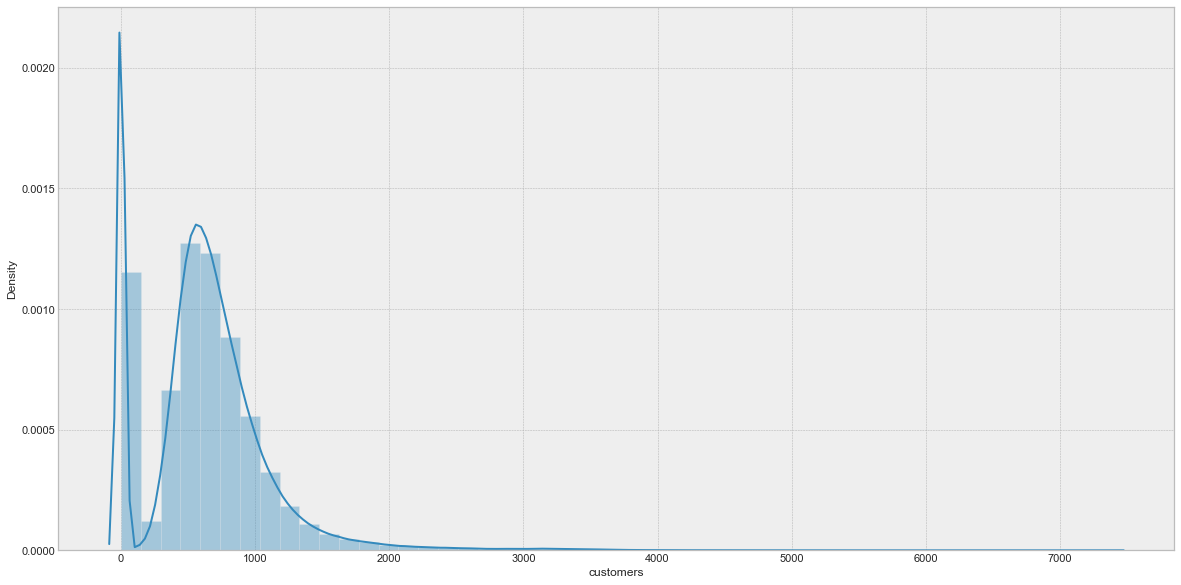

In [440]:
sns.distplot( df1['customers'] )

## 1.7 Change Types

**int8 / uint8 :** consumes 1 byte of memory, range between -128/127 or 0/255

**bool :** consumes 1 byte, true or false

**float16 / int16 / uint16:** consumes 2 bytes of memory, range between -32768 and 32767 or 0/65535

**float32 / int32 / uint32 :** consumes 4 bytes of memory, range between -2147483648 and 2147483647

**float64 / int64 / uint64:** consumes 8 bytes of memory

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [18]:
# Numerical Variables

df1.store                        = df1.store.astype('int16') 
df1.day_of_week                  = df1.day_of_week.astype('int8')
df1.sales                        = df1.sales.astype('int16')
df1.customers                    = df1.customers.astype('int16')
df1.open                         = df1.open.astype('int8')
df1.promo                        = df1.promo.astype('int8')
df1.school_holiday               = df1.school_holiday.astype('int8')
df1.competition_distance         = df1.competition_distance.astype('int32')
df1.competition_open_since_month = df1.competition_open_since_month.astype('int8')
df1.competition_open_since_year  = df1.competition_open_since_year.astype('int16')
df1.promo2                       = df1.promo2.astype('int8')
df1.promo2_since_week            = df1.promo2_since_week.astype('int8')
df1.promo2_since_year            = df1.promo2_since_year.astype('int16')
df1.is_promo                     = df1.is_promo.astype('int8')

# Categorical Variables
df1.state_holiday  = df1.state_holiday.astype('category')
df1.store_type     = df1.store_type.astype('category')
df1.assortment     = df1.assortment.astype('category')
df1.promo_interval = df1.promo_interval.astype('category')
df1.month_map      = df1.month_map.astype('category')

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int16         
 1   day_of_week                   1017209 non-null  int8          
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int16         
 4   customers                     1017209 non-null  int16         
 5   open                          1017209 non-null  int8          
 6   promo                         1017209 non-null  int8          
 7   state_holiday                 1017209 non-null  category      
 8   school_holiday                1017209 non-null  int8          
 9   store_type                    1017209 non-null  category      
 10  assortment                    1017209 non-null  category      
 11

C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='customers', ylabel='Density'>

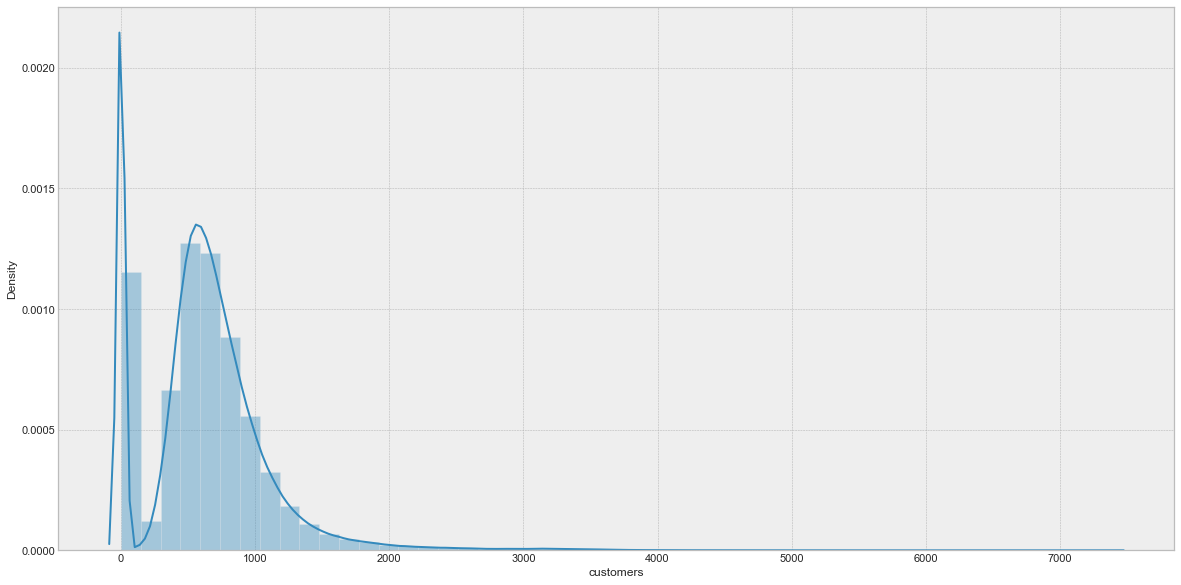

In [19]:
# analisando a distribuição de variáveis
sns.distplot( df1['customers'] )

## 1.8.2 Categorical Attributes

In [20]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

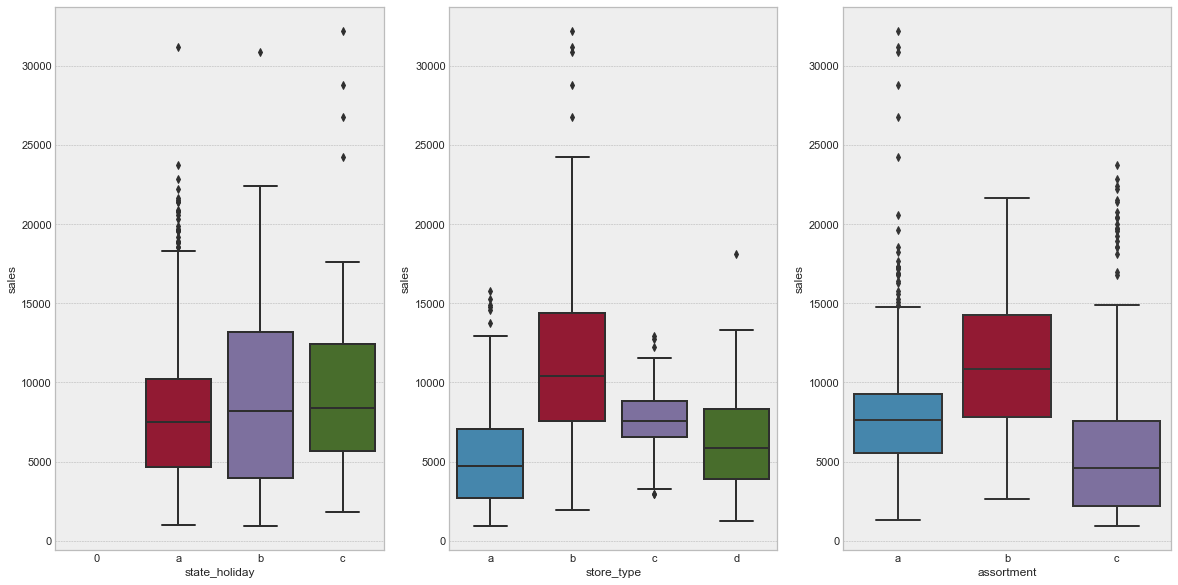

In [21]:
aux1 = df1[ (df1['state_holiday'] !='0' ) & ( df1['sales'] > 0 ) ]

plt.subplot(1,3,1)
sns.boxplot( x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot( x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot( x='assortment', y='sales', data=aux1)

# 2.0 FEATURE ENGINEERING

In [22]:
df2 = df1.copy()

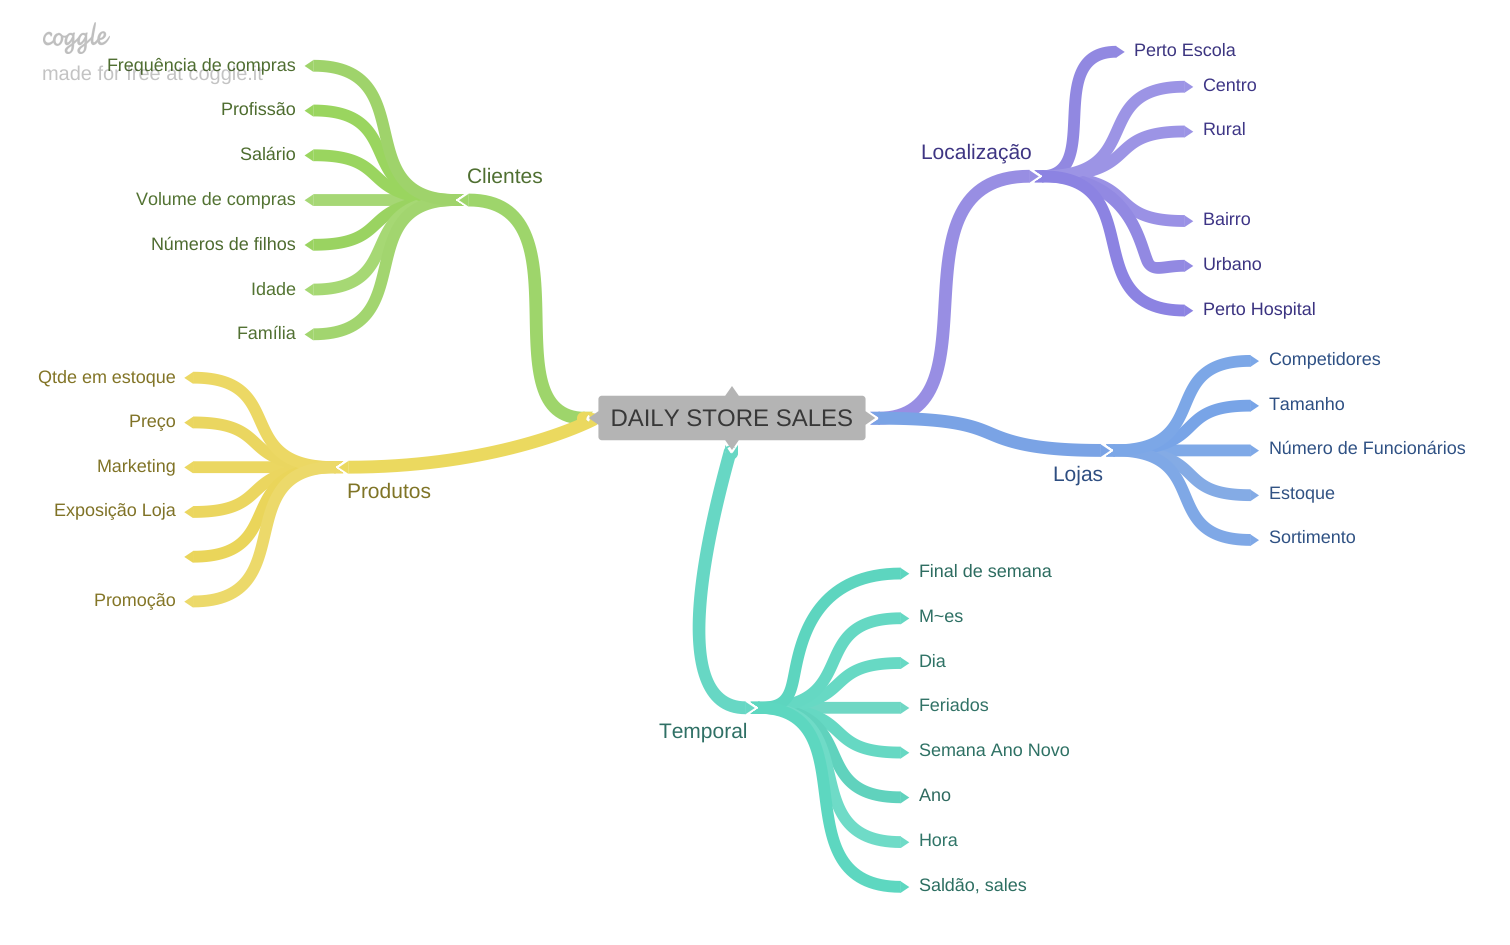

In [23]:
Image("img/DAILY_STORE_SALES.png")

## 2.1 Creating Hypotheses

### 2.1.1 Store assumptions

**1.** Lojas com maior número de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.2 Product assumptions

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos deveriam vender mais.

**3.** Lojas com produtos com preços menores deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3 Time assumptions

**1.** Lojas abertas durante o feriado de natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais deposi do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Hypotheses Final List ( We must prioritize the assumptions that we have the data now. )

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.## 1.1

**7.** Lojas abertas durante o feriado de natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais deposi do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [24]:
# year
df2['year'] = df2['date'].dt.year 

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ( (df2['date'] - df2['competition_since']) /30 ).apply(lambda x: x.days).astype('int16')

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7))
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'xmas' if x=='c' else 'regular_day')


C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


In [25]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 VARIABLE FILTERING

In [26]:
df3 = df2.copy()
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Rows Filtering

In [27]:
df3=df3[(df3['open']!=0) & (df3['sales']>0)]

## 3.1 Variable Filtering

In [28]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 EXPLORATORY DATA ANALYSIS

In [29]:
df4 = df3.copy()

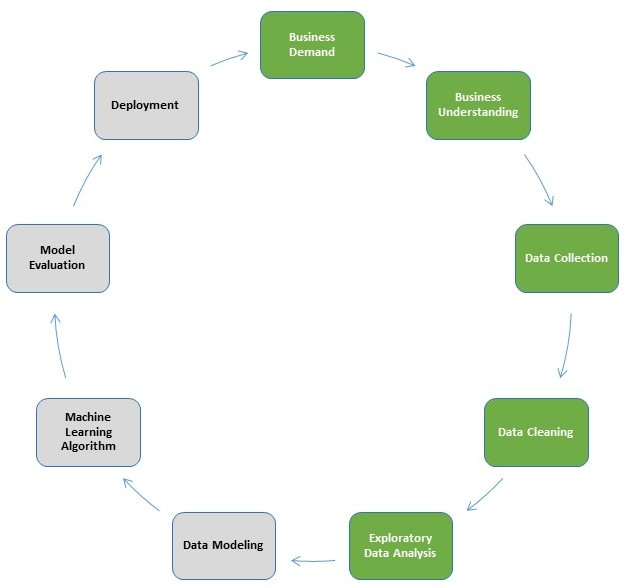

In [30]:
Image("img/crisp4.jpg")

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

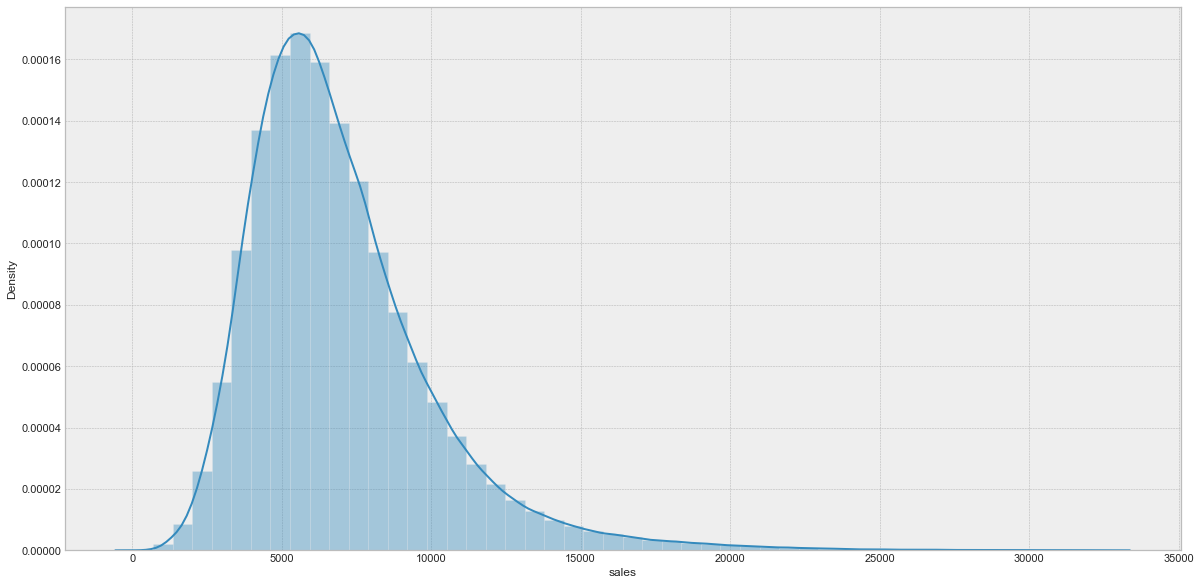

In [31]:
sns.distplot(df4['sales'])

### 4.1.2 Numerical Variable

**Histograma**

**Definição:** uma uma representação gráfica em formato de retângulos cuja área é proporcional à frequência de uma variável quantitativa e cuja largura é igual ao intervalo de classe.

**Para que serve:** Um histograma é uma representação gráfica da distribuição de uma variável quantitativa contínua. Com o histograma pode-se visualizar a dispersão/concentração dos dados, bem como a assimetria/simetria dos dados. É muito utilizado para visualizar toda a distribuição de uma variável quantitativa. Foi introduzida pela primeira vez por Karl Pearson (OBS - É muito parecido com o gráfico de barras).

In [1]:
num_attributes.hist(bins=25);

NameError: name 'num_attributes' is not defined

### 4.1.3 Categorical Variable

In [33]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: category
Categories (3, object): ['basic', 'extra', 'extended']

C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an 

<AxesSubplot:xlabel='sales', ylabel='Density'>

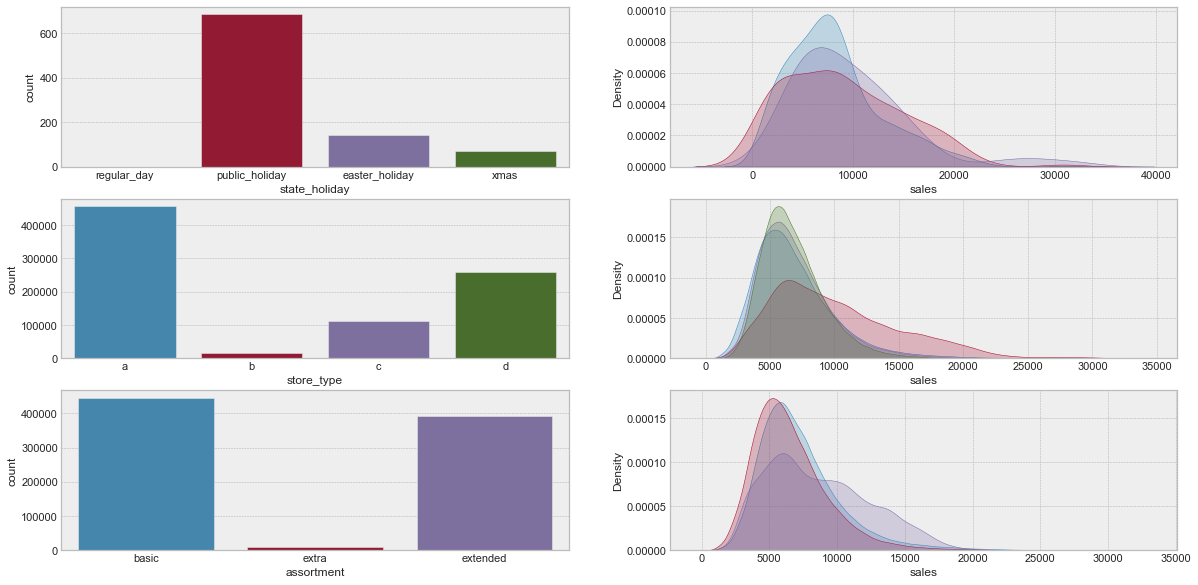

In [34]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True) 
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True) 
sns.kdeplot(df4[df4['state_holiday'] == 'xmas']['sales'], label='xmas', shade=True) 

# store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True) 
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True) 
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True) 
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True) 

# assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extendend', shade=True) 
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True) 
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

## 4.2 Bivariate Analysis

### **H1.** Lojas com maior sortimento deveriam vender mais.

**Falsa.** Lojas com maior sortimento VENDEM MENOS.

<AxesSubplot:xlabel='year_week'>

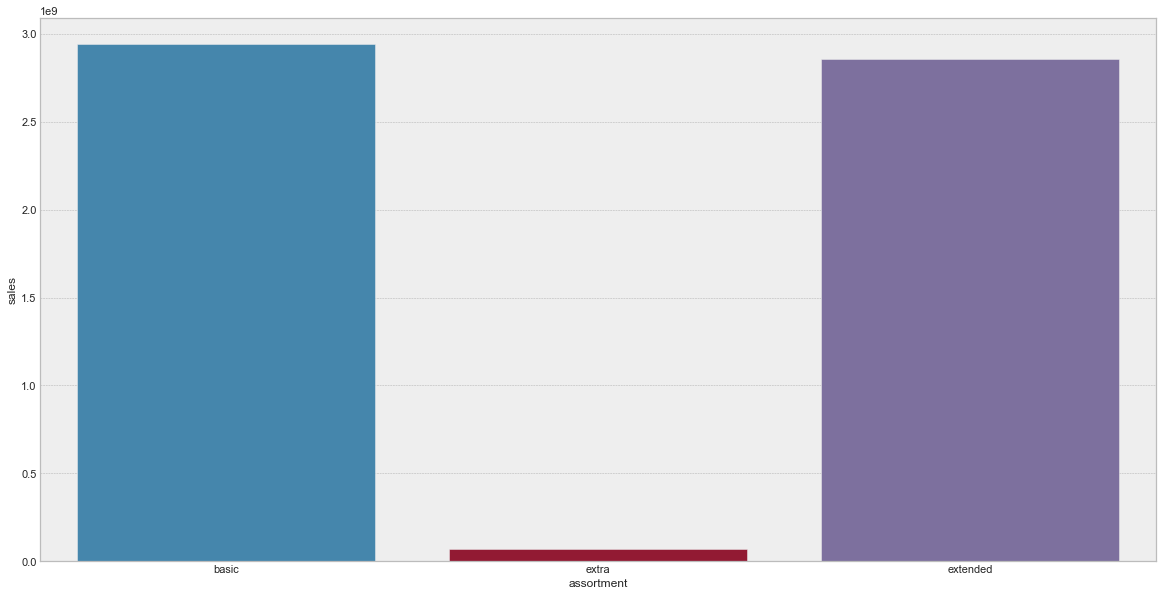

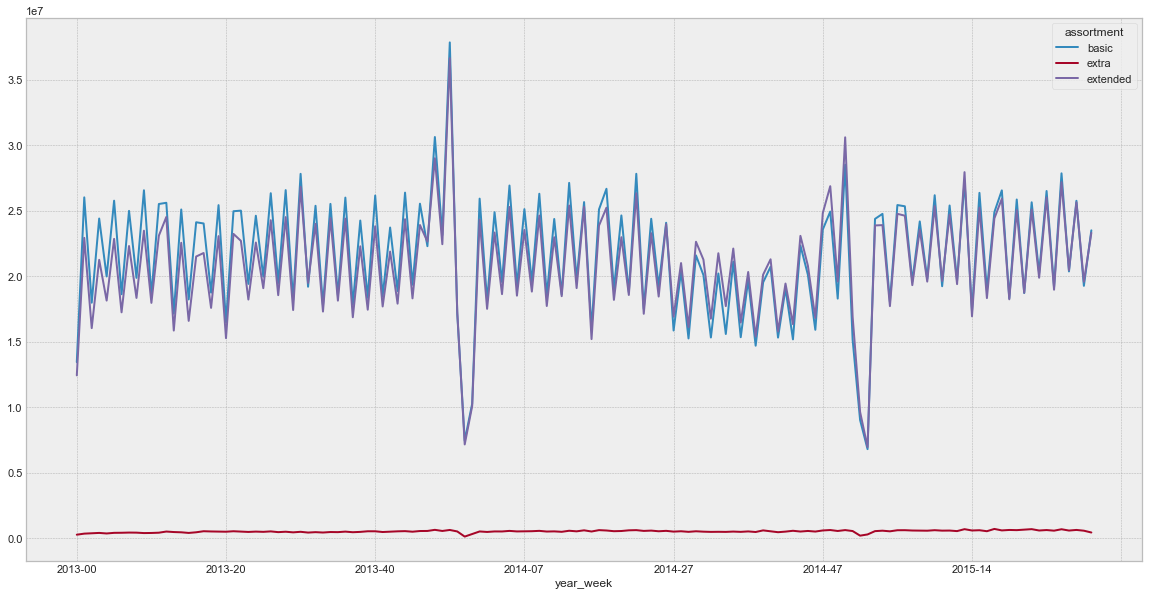

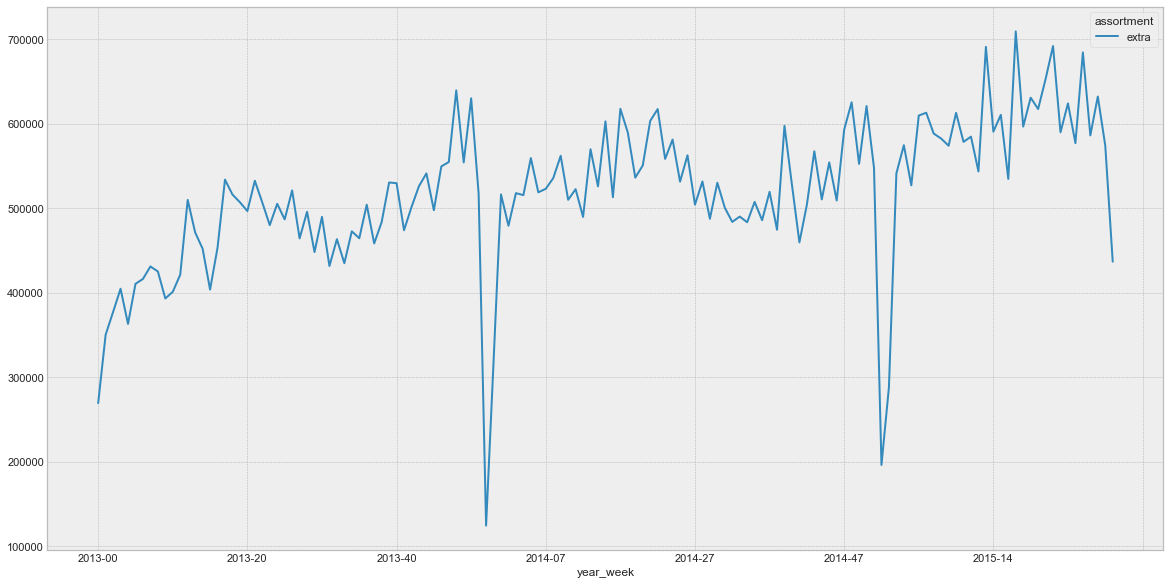

In [35]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['assortment', 'year_week', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot( index='year_week', columns='assortment', values='sales').plot()

### **H2.** Lojas com competidores mais próximos deveriam vender menos.

**Falsa.** Lojas com competidores mais próximos VENDEM MAIS.

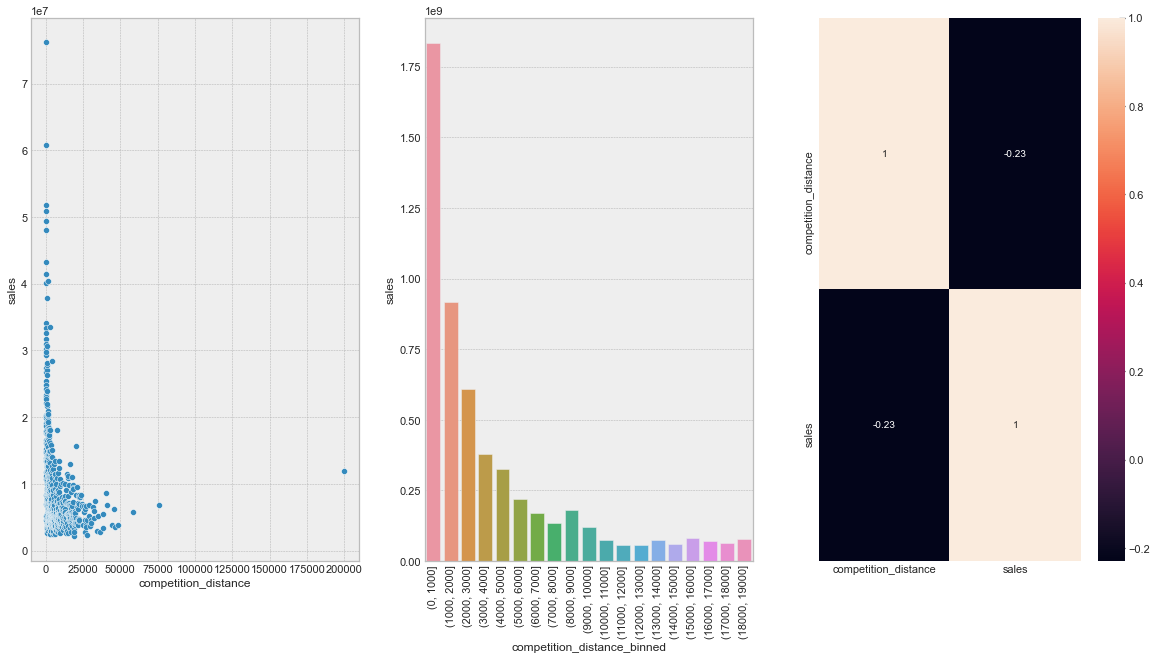

In [36]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot( x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2)
# agrupa em faixas de 1000
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);


**Interpretando a Correlação de Pearson. Este coeficiente, normalmente representado por ρ assume apenas valores entre -1 e 1.**

ρ = 1 Significa uma correlação perfeita positiva entre as duas variáveis.

ρ =-1 Significa uma correlação negativa perfeita entre as duas variáveis - Isto é, se uma aumenta, a outra sempre diminui.

ρ = 0 Significa que as duas variáveis não dependem linearmente uma da outra. No entanto, pode existir uma dependência não linear.
      Assim, o resultado ρ =0 deve ser investigado por outros meios.

**-** 0.9 para mais ou para menos indica uma correlação muito forte.

**-** 0.7 a 0.9 positivo ou negativo indica uma correlação forte.

**-** 0.5 a 0.7 positivo ou negativo indica uma correlação moderada.

**-** 0.3 a 0.5 positivo ou negativo indica uma correlação fraca.

**-** 0 a 0.3 positivo ou negativo indica uma correlação desprezível.

### **H3.** Lojas com competidores há mais tempo deveriam vender mais.

**Falsa.** Lojas com competidores há mais tempo VENDEM MENOS.

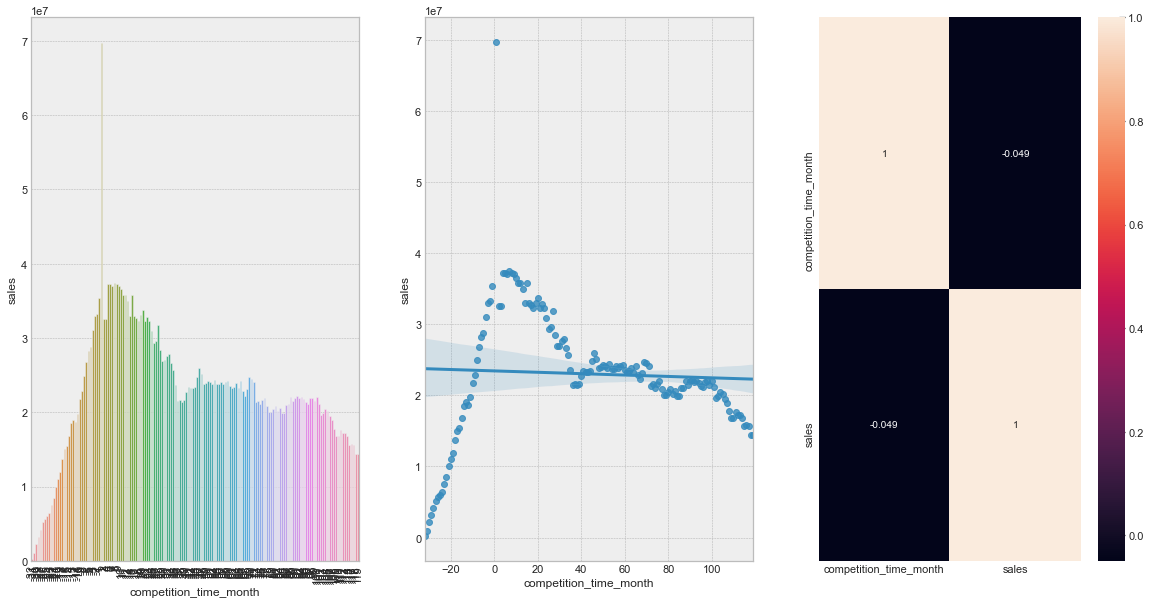

In [37]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[( aux1['competition_time_month']< 120) & (aux1['competition_time_month']!= 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot( x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap( aux2.corr( method='pearson'), annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**Falsa** Lojas com promoções ativas por mais tempo vendemmenos, depois de um certo tempo de promoção.

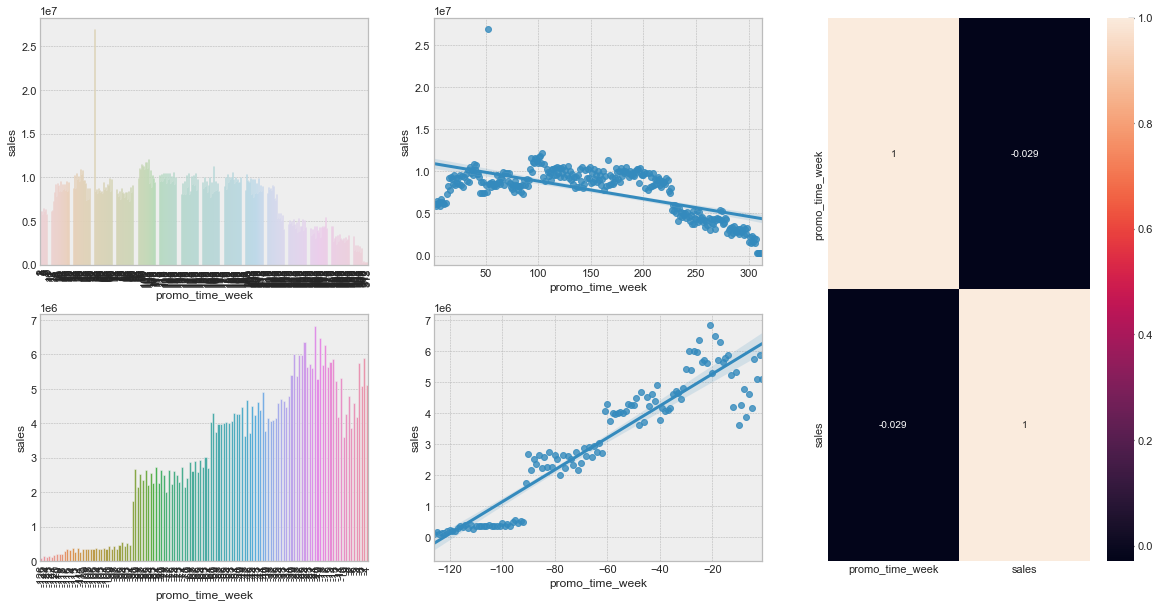

In [38]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3) # monta grid 2 linha e 3 colunas, pra receber os gráficos

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']>0] # promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks( rotation=90 )

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']<0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks( rotation=90 )

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap( aux1.corr(method='pearson'), annot=True);


### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.

**Falsa** Lojas com mais promoções consecutivas vendem menos.

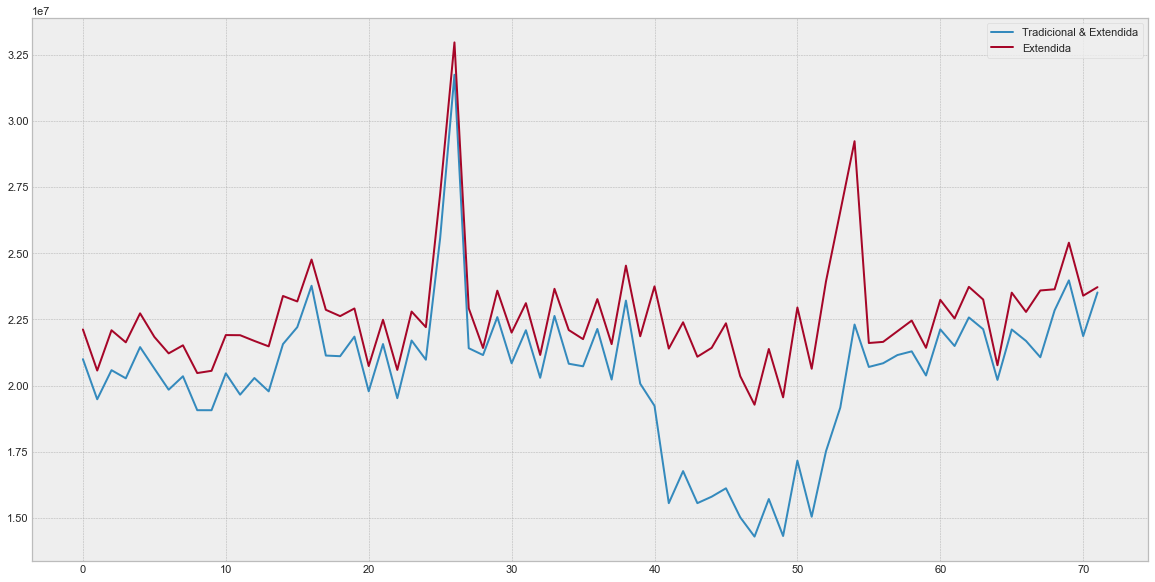

In [39]:
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)
ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

### **H7.** Lojas abertas durante o feriado de natal deveriam vender mais.
**Falsa** Lojas abertas durante o feriado de natal vendem menos.

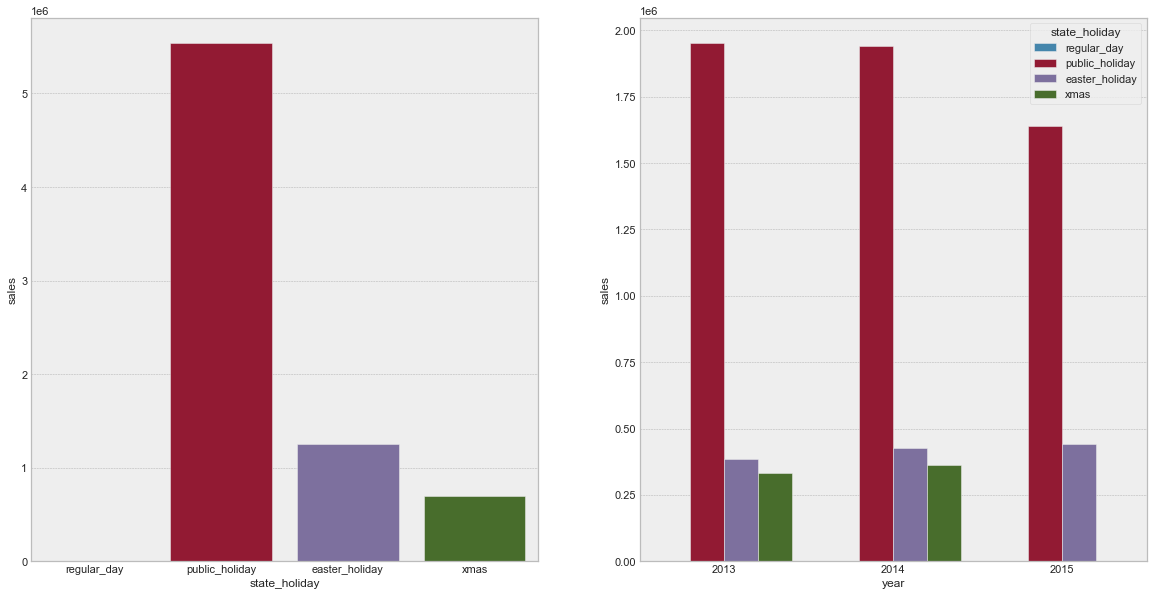

In [40]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **H8.** Lojas deveriam vender mais ao longo dos anos.

**Falso** Há uma variação, não mas temos um crescimento.

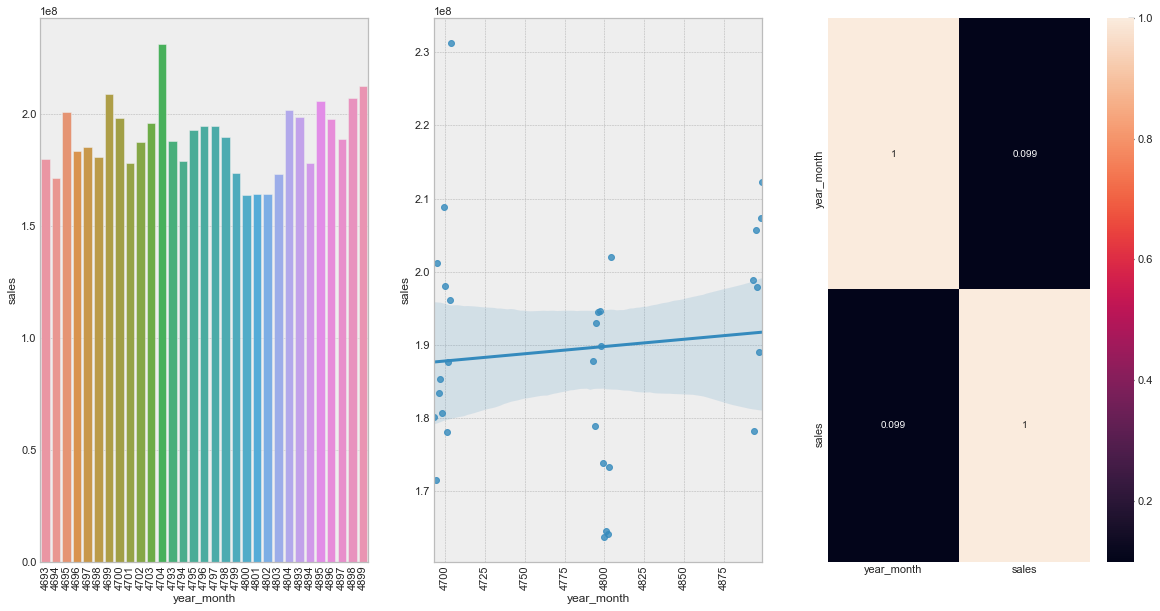

In [41]:
df4['year_month'] = df4['date'].dt.strftime('%Y%m').astype(int16)
aux1 = df4[['year_month', 'sales']].groupby('year_month').sum().reset_index()

aux1.head()

plt.subplot(1, 3, 1)
sns.barplot(x='year_month', y='sales', data=aux1)
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.regplot(x='year_month', y='sales', data=aux1)
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);


### **H9.** Lojas deveriam vender mais no segundo semestre do ano.

**Falsa** Lojas vendem menos no segundo semestre do ano.

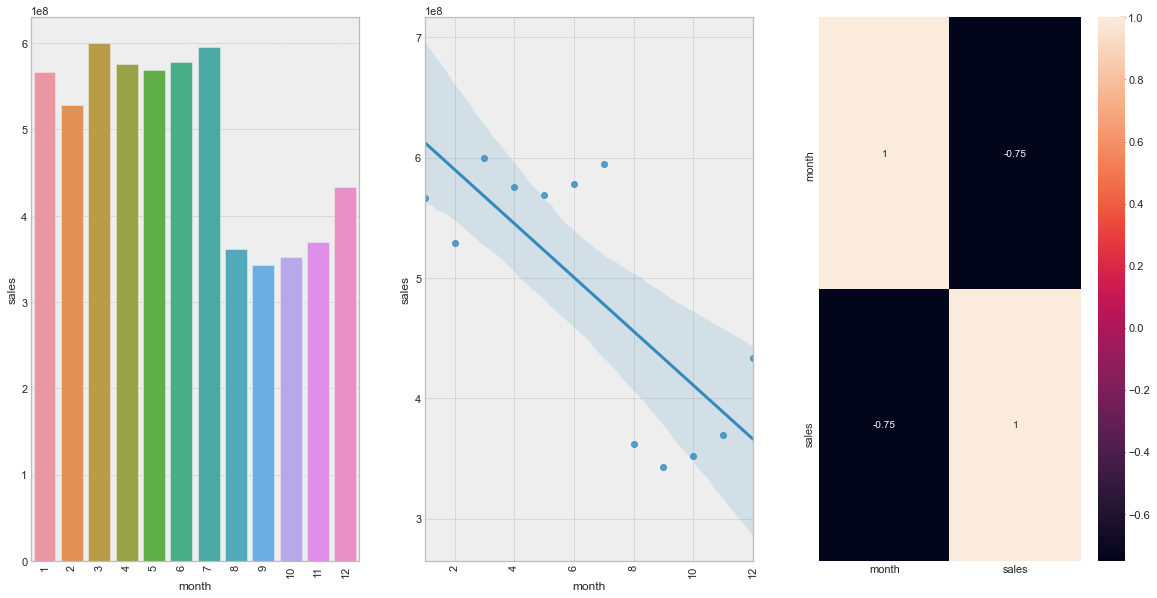

In [42]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

aux1.head()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**Verdadeira** Lojas vendem mais após o dia 10.

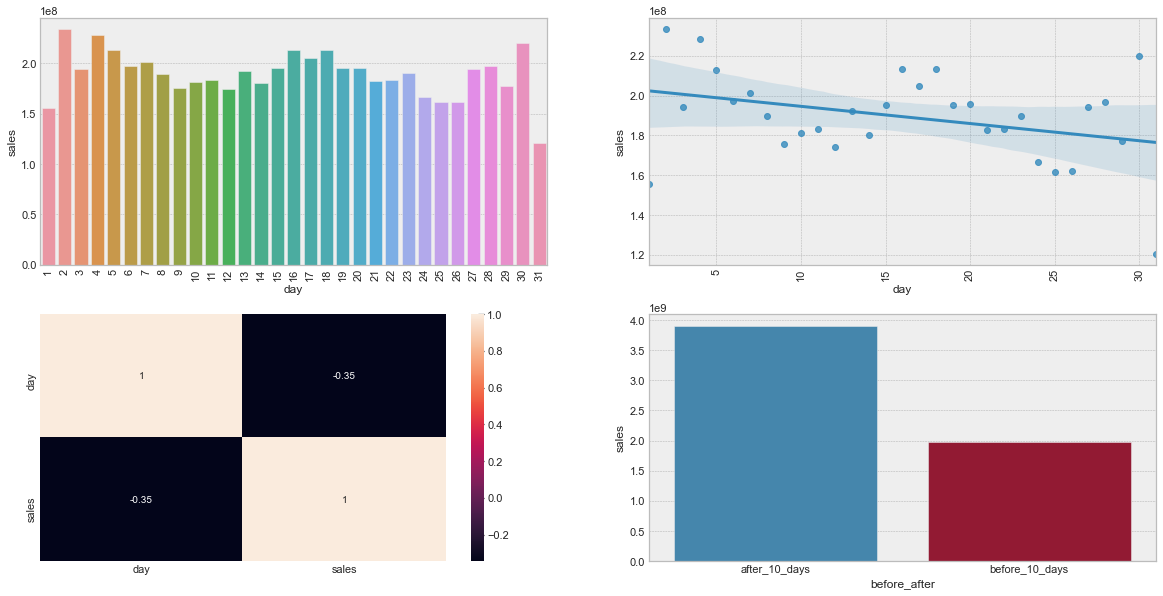

In [43]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

aux1.head()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)
plt.xticks(rotation=90)

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)
plt.xticks(rotation=90);

plt.subplot(2, 2, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<=10 else 'after_10_days')
aux2=aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2);


### **H11.** Lojas deveriam vender menos aos finais de semana.

**VERdadeira** Lojas vendem menos no final de semana.

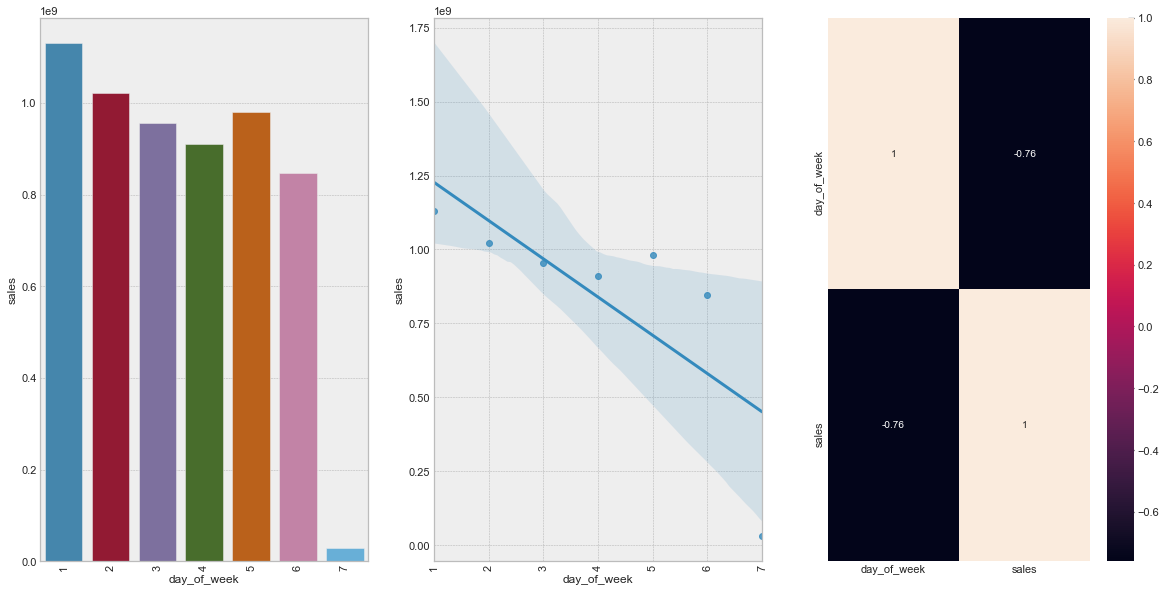

In [44]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

aux1.head()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);

### **H12.** Lojas deveriam vender menos durante os feriados escolares.

**Verdadeira** Lojas vendem menos durante os feriados escolares, exceto julho e agosto.

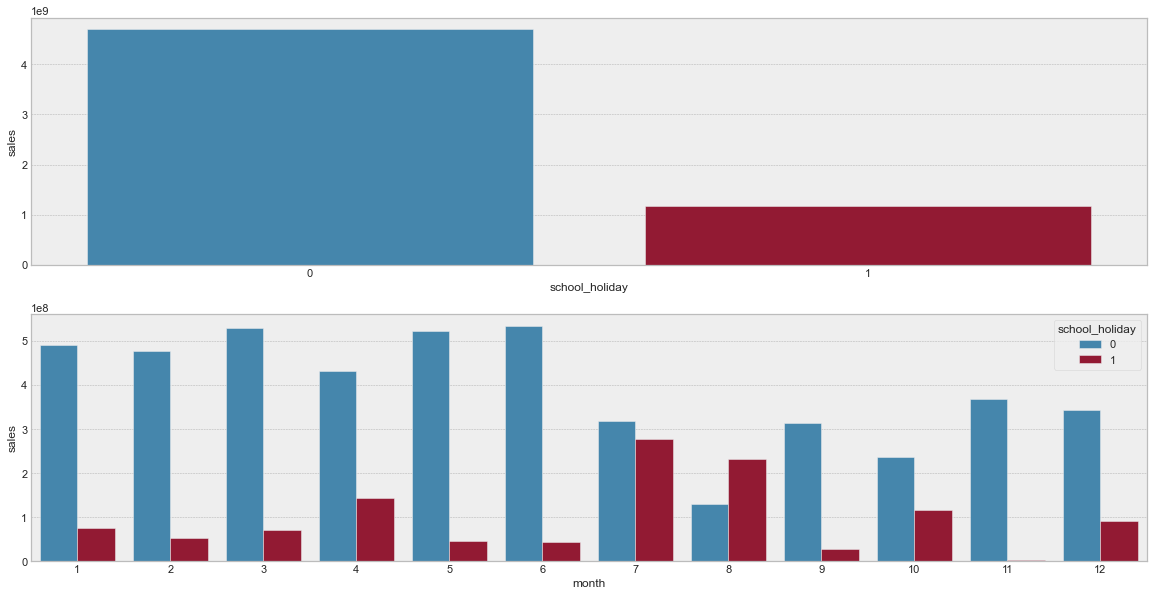

In [45]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

aux1 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux1);

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

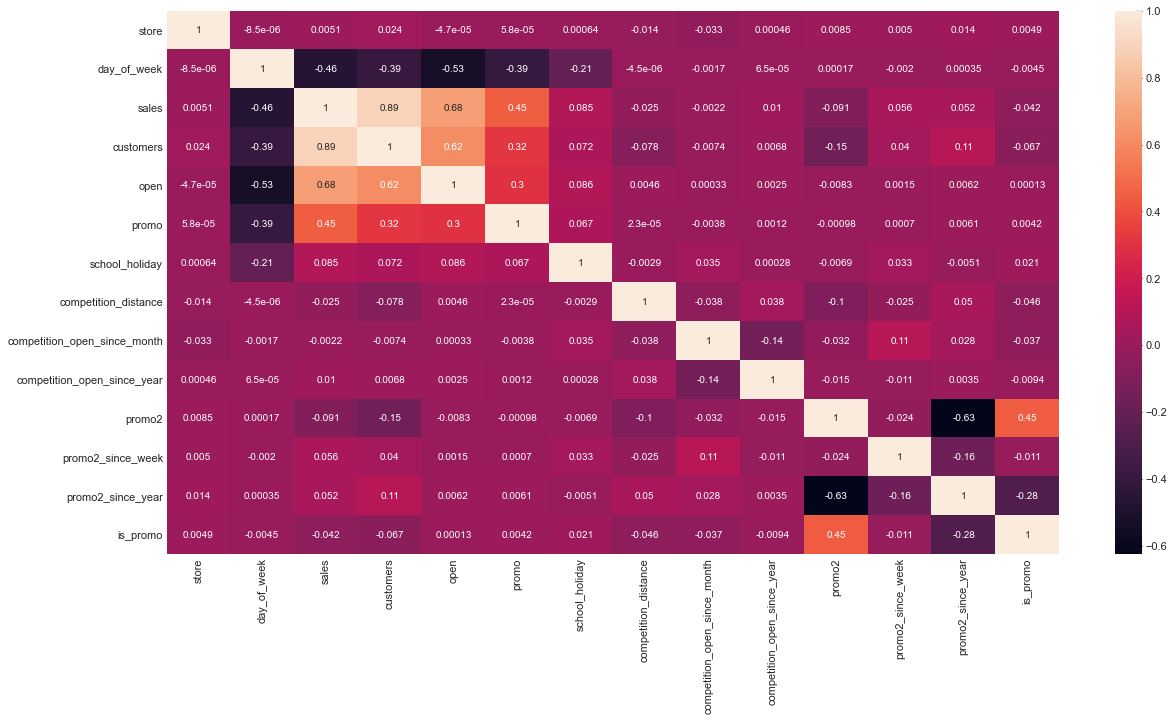

In [46]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.1 Categorical Attributes

In [47]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844295 entries, 0 to 1017190
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   store                         844295 non-null  int16         
 1   day_of_week                   844295 non-null  int8          
 2   date                          844295 non-null  datetime64[ns]
 3   sales                         844295 non-null  int16         
 4   promo                         844295 non-null  int8          
 5   state_holiday                 844295 non-null  category      
 6   school_holiday                844295 non-null  int8          
 7   store_type                    844295 non-null  category      
 8   assortment                    844295 non-null  category      
 9   competition_distance          844295 non-null  int32         
 10  competition_open_since_month  844295 non-null  int8          
 11  competition_

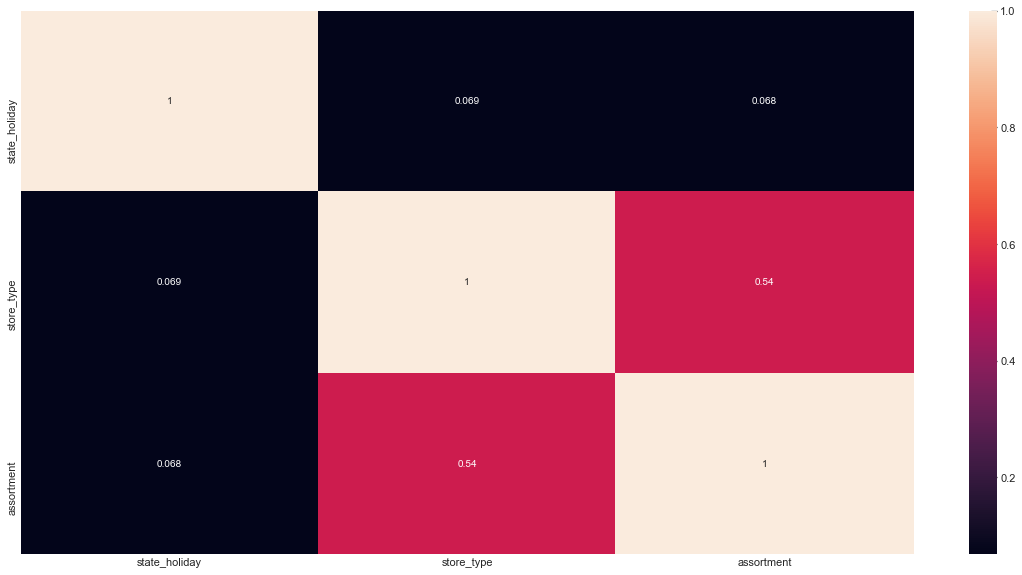

In [48]:
# only Categorical Attributes
a = df4.select_dtypes( include='category')

# Calculate Cramer_V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final Dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                 'store_type': [a4, a5, a6],
                 'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True);


# 5.0 DATA PREPARATION

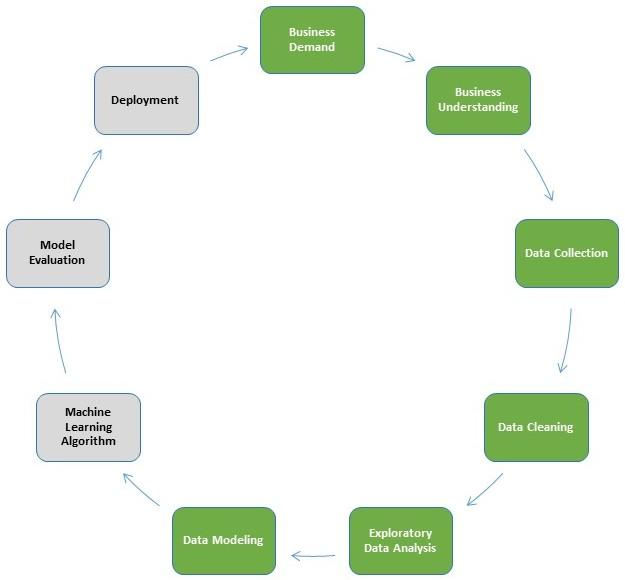

In [49]:
Image("img/crisp5.jpg")

In [311]:
df5 = df4.copy()

## 5.1 Normalization

**Used when we have a normal data distribution.**

## 5.2 Rescaling

**- Min-Max Scaler (Sensível a Outlier)**

**- Robust Scaler**

C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an 

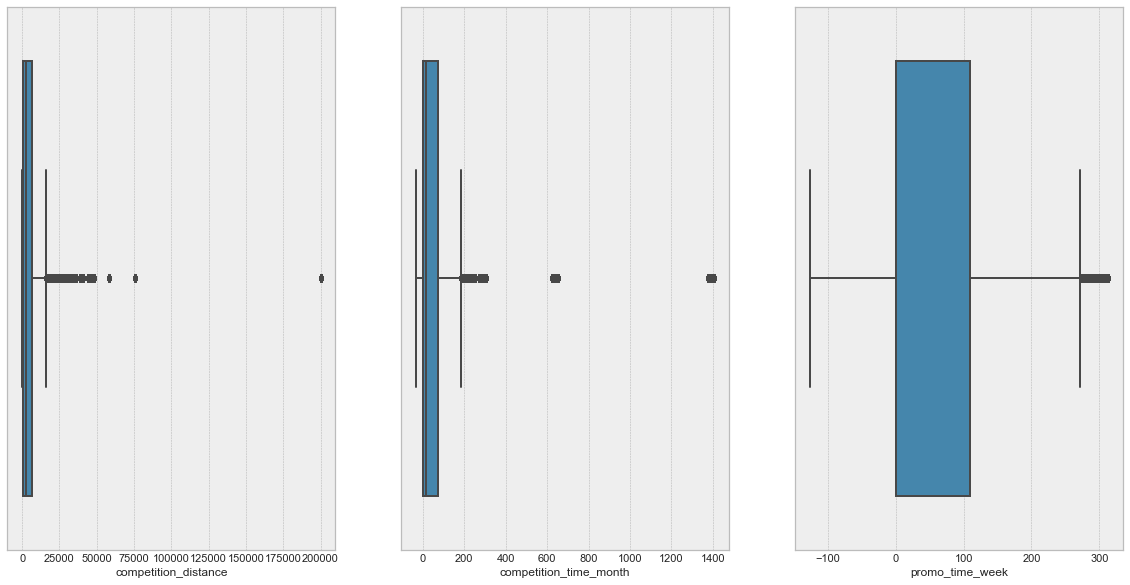

In [209]:
# Identificando Outliers
plt.subplot(1,3,1)
sns.boxplot( df5['competition_distance']);

plt.subplot(1,3,2)
sns.boxplot( df5['competition_time_month']);

plt.subplot(1,3,3)
sns.boxplot( df5['promo_time_week']);


In [335]:
rs = RobustScaler()
mms = MinMaxScaler()

# Aplica RobustScaler nas variáveis com Outliers

# Competititon distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump( rs, open('parameter/competition_distance_scaler.pkl', 'wb'))
                                                   
# Competititon time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump( rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# Aplica MinMaxScaler nas variáveis sem Outliers

# Promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump( rs, open('parameter/promo_time_week_scaler.pkl', 'wb'))
                                               
# Year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump( rs, open('parameter/year_scaler.pkl', 'wb'))

## 5.3 Transformation

### 5.3.1 Encoding

In [313]:
# State_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump(le, open('parameter/store_type_encoding.pkl', 'wb'))

# assortment
assortment_dict = { 'basic':1, 'extra':2, 'extended':3 }
df5['assortment'] = df5['assortment'].map( assortment_dict ).astype('int8')

In [212]:
df5.dtypes

store                                    int16
day_of_week                               int8
date                            datetime64[ns]
sales                                    int16
promo                                     int8
school_holiday                            int8
store_type                               int32
assortment                                int8
competition_distance                   float64
competition_open_since_month              int8
competition_open_since_year              int16
promo2                                    int8
promo2_since_week                         int8
promo2_since_year                        int16
is_promo                                  int8
year                                   float64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_since               datetime64[ns]
competition_t

### 5.3.2 Response Variable Transformation

In [213]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3 Nature Transformation

In [214]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin(x * (2. * np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos(x * (2. * np.pi/7) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin(x * (2. * np.pi/12) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos(x * (2. * np.pi/12) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin(x * (2. * np.pi/30) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos(x * (2. * np.pi/30) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin(x * (2. * np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos(x * (2. * np.pi/52) ) )


# 6.0 FEATURE SELECTION

In [225]:
df6 = df5.copy()

## 6.1 Split Dataframe into training and test dataset

In [226]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week', 'year_month']
df6 = df6.drop( cols_drop, axis=1)

In [227]:
dt_aux = df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)
dt_aux = str(dt_aux).split('-')
dt_aux = '{}-{}-{}'.format(dt_aux[0], dt_aux[1], dt_aux[2][:2])

# training dataset
X_train = df6[df6['date'] < dt_aux]
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= dt_aux]
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTraining Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Training Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [228]:
# training and teste dataset for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n)

## 6.3 Manual Feature Selection

In [251]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 MACHINE LEARNING MODELLING

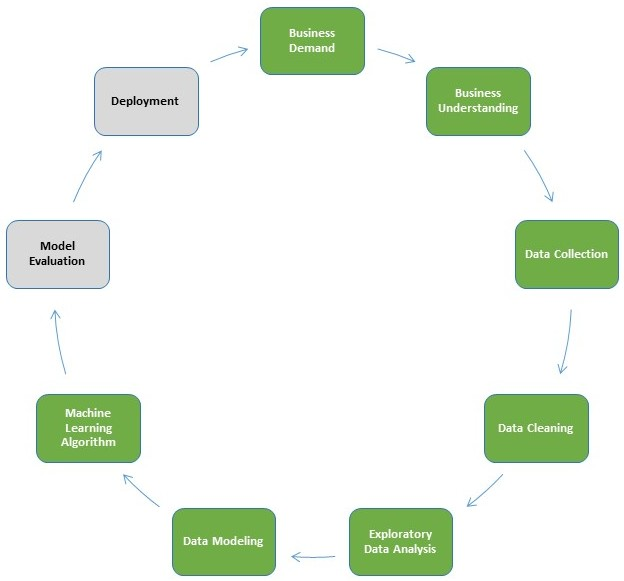

In [302]:
Image("img/crisp6.jpg")

In [231]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model - Baseline

In [165]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns={'sales':'predictions'})
aux1 = pd.merge( aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']
#aux1['predictions']

#performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline) )
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.234375,0.45526,1830.300537


## 7.2 Linear Models

### 7.2.1 Linear Regression Model

In [173]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1866.249887,0.292651,2665.581455


### 7.2.2 Linear Regression Model - Cross Validation

In [299]:
lr_result_cv = cross_validation ( x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,2080.23 +/- 294.38,0.3 +/- 0.02,2945.48 +/- 462.9


### 7.2.3 Linear Regression Regularized Model - Lasso

In [237]:
# model
lrr = Lasso( alpha=0.01 ).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1890.939225,0.289067,2739.124644


### 7.2.4 Linear Regression Regularized Model Lasso - Cross Validation

In [300]:
lrr_result_cv = cross_validation ( x_training, 5, 'Linear Regression - Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,2114.98 +/- 340.16,0.29 +/- 0.01,3050.92 +/- 498.7


## 7.3 Nonlinear Models

### 7.3.1 Random Forest Regressor

In [179]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.701375,0.100352,1004.279762


### 7.3.2 Random Forest Regressor - Cross Validation

In [301]:
rf_result_cv = cross_validation ( x_training, 5, 'Random Forest', rf, verbose=False)
rf_result_cv

,Model Name,MAE,MAPE,RMSE
0,Random Forest,835.74 +/- 216.18,0.12 +/- 0.02,1250.86 +/- 318.02


### 7.3.3 XGBoost Regressor

In [234]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,877.68512,0.128365,1287.53894


### 7.3.4 XGBoost Regressor - Cross Validation

In [301]:
xgb_result_cv = cross_validation ( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
xgb_result_cv

,Model Name,MAE,MAPE,RMSE
0,Random Forest,835.74 +/- 216.18,0.12 +/- 0.02,1250.86 +/- 318.02


## 7.4 Compare Model´s Performance

### 7.4.1 Single Performance

In [238]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.701375,0.100352,1004.279762
0,XGBoost Regressor,877.685120,0.128365,1287.538940
0,Average Model,1354.234375,0.455260,1830.300537
0,Linear Regression,1866.249887,0.292651,2665.581455
0,Linear Regression - Lasso,1890.939225,0.289067,2739.124644


### 7.4.1 Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values('RMSE')

# 8.0 HYPERPARAMETER FINE TUNNING

## 81. Random Search

In [332]:
# criação de parâmetros
param = {
         'n_estimators': [1500, 1700, 2500, 3000, 3500],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytee': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]
        }

In [333]:
# executando o fine tunning
MAX_EVAL = 2
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    # choose values for parameters randomly
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print(hp)
    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'],
                                  eta=hp['eta'],
                                  max_depth=hp['max_depth'],
                                  subsample=hp['subsample'],
                                  colsample_bytee=hp['colsample_bytee'],
                                  min_child_weight=hp['min_child_weight']).fit( x_train, y_train )

    # performance
    xgb_result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False )
    final_result = pd.concat( [final_result, result] )

final_result

{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytee': 0.9, 'min_child_weight': 3}


KeyboardInterrupt: 

## 8.2 Final Model

In [314]:
param_tuned = {
         'n_estimators': 30,
         'eta': 0.03,
         'max_depth': 9,
         'subsample': 0.1,
         'colsample_bytee': 0.7,
         'min_child_weight': 15
        }

In [315]:
# final model after fine tunning

model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytee'],
                                    min_child_weight=param_tuned['min_child_weight']).fit( x_train, y_train )
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,2495.842773,0.309502,3354.872803


# 9.0 ERROR TRANSLATION AND INTERPRETATION

In [316]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## 9.1 Business Performance

In [317]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

#MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] )).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] )).reset_index().rename(columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge( df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [319]:
# order by WORST MAPE
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
841,842,212476.531250,197848.950195,227104.112305,14627.581055,0.714102
816,817,227434.156250,212721.350586,242146.961914,14712.805664,0.700067
697,698,189323.359375,177634.531250,201012.187500,11688.828125,0.693941
787,788,209544.984375,197549.144531,221540.824219,11995.839844,0.675880
261,262,296577.406250,282283.019531,310871.792969,14294.386719,0.665791


<AxesSubplot:xlabel='store', ylabel='MAPE'>

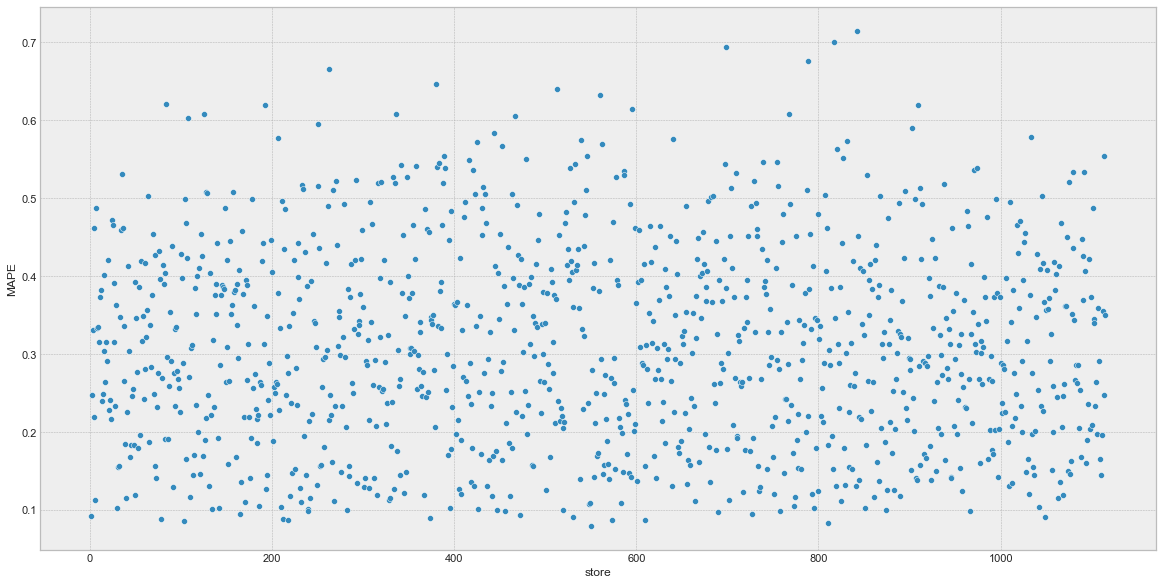

In [321]:
sns.scatterplot( x='store', y='MAPE', data=df92)


## 9.2 Total Performance

In [331]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenarios', 0:'values'})
df93['values'] = df93['values'].map('R$ {:,.2f}'.format)
df93

,Scenarios,values
0,predictions,"R$ 190,563,168.00"
1,worst_scenario,"R$ 187,784,872.92"
2,best_scenario,"R$ 193,341,480.42"


## 9.3 Machine Learning Performance

C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\oi60339\.conda\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future 

<AxesSubplot:xlabel='predictions', ylabel='error'>

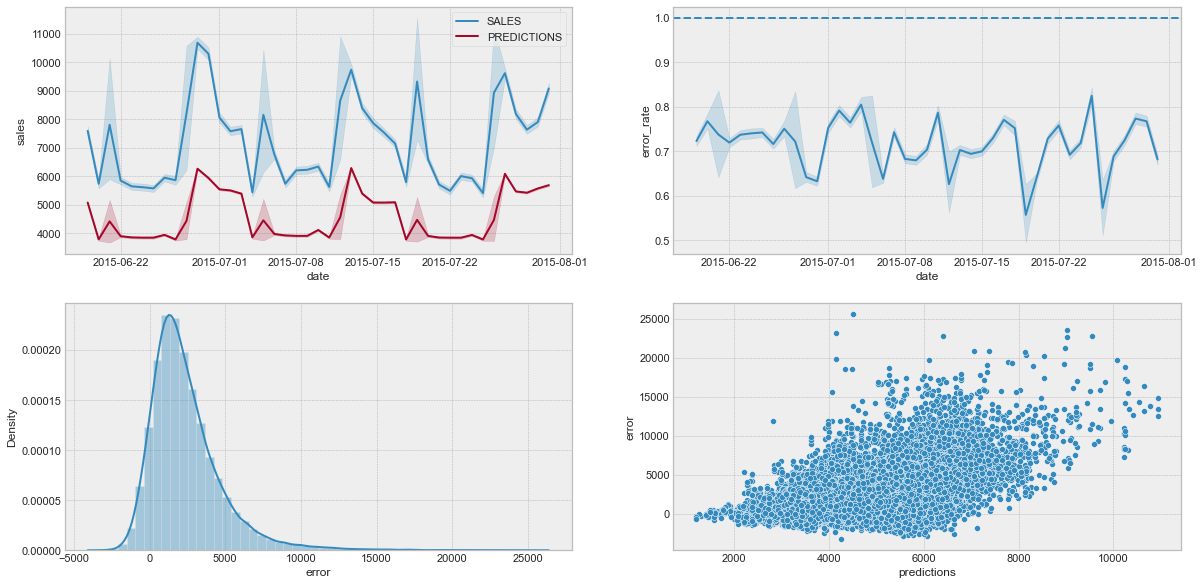

In [334]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

plt.subplot(2,2,1)
sns.lineplot( x='date', y='sales', data=df9, label='SALES')
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot( x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2,2,3)
sns.distplot( df9['error'])


plt.subplot(2,2,4)
sns.scatterplot( df9['predictions'], df9['error'])


# 10.0 DEPLOY MODEL TO PRODUCTION

In [340]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open('model_rossmann.pkl', 'wb') )

## 10.1 Rossman Class

In [8]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):

    def __init__(self):
        self.home_path='C:/DADOS/Fabyo/InteligenciaArtificial/DataScienceEmProducao/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb' ) )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb' ) )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb' ) )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb' ) )
        self.store_type_encoding           = pickle.load( open( self.home_path + 'parameter/store_type_encoding.pkl', 'rb' ) )
        
    def data_cleaning( self, df1 ):
        # 1.1 Rename Columns
        cols_old = [ 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                     'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                     'CompetitionDistance', 'CompetitionOpenSinceMonth',
                     'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                     'Promo2SinceYear', 'PromoInterval']

        # funcao para transformar os nomes de campos de CamelCase para snakecase
        snakecase = lambda x: inflection.underscore(x)

        cols_new = list( map (snakecase, cols_old) )

        #rename
        df1.columns = cols_new

        ## 1.4 Data Types

        # Altera tipo de dados de object para date
        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.6 Fillout NA

        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        #promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        #promo_interval
        month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr',  5:'May',  6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
        df1['promo_interval'].fillna(0, inplace=True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1 )

        ## 1.7 Descriptive Statistical

        # criando dataframe por tipo de dados
        num_attributes = df1.select_dtypes( exclude=['object', 'datetime64[ns]'] )
        cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

        ## 1.7.1 Numerical Attributes

        ## 1.7 Change Types
        # **int8 / uint8 :** consumes 1 byte of memory, range between -128/127 or 0/255
        # **bool :** consumes 1 byte, true or false
        # **float16 / int16 / uint16:** consumes 2 bytes of memory, range between -32768 and 32767 or 0/65535
        # **float32 / int32 / uint32 :** consumes 4 bytes of memory, range between -2147483648 and 2147483647
        # **float64 / int64 / uint64:** consumes 8 bytes of memory
        # Numerical Variables

        df1.store                        = df1.store.astype('int16') 
        df1.day_of_week                  = df1.day_of_week.astype('int8')
        df1.open                         = df1.open.astype('int8')
        df1.promo                        = df1.promo.astype('int8')
        df1.school_holiday               = df1.school_holiday.astype('int8')
        df1.competition_distance         = df1.competition_distance.astype('int32')
        df1.competition_open_since_month = df1.competition_open_since_month.astype('int8')
        df1.competition_open_since_year  = df1.competition_open_since_year.astype('int16')
        df1.promo2                       = df1.promo2.astype('int8')
        df1.promo2_since_week            = df1.promo2_since_week.astype('int8')
        df1.promo2_since_year            = df1.promo2_since_year.astype('int16')
        df1.is_promo                     = df1.is_promo.astype('int8')

        # Categorical Variables
        df1.state_holiday  = df1.state_holiday.astype('category')
        df1.store_type     = df1.store_type.astype('category')
        df1.assortment     = df1.assortment.astype('category')
        df1.promo_interval = df1.promo_interval.astype('category')
        df1.month_map      = df1.month_map.astype('category')
        
        return df1
    
    def feature_engineering( self, df2 ):
        # year
        df2['year'] = df2['date'].dt.year 

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ( (df2['date'] - df2['competition_since']) /30 ).apply(lambda x: x.days).astype('int16')

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7))
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'xmas' if x=='c' else 'regular_day')

        # 3.0 FILTRAGEM DE VARIÁVEIS

        ## 3.1 Filtragem das Linhas

        df2=df2[(df2['open']!=0)]

        ## 3.1 Filtragem das Variáveis

        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    def data_preparation( self, df5 ):
        # Rescaling
        # Aplica RobustScaler nas variáveis com Outliers        
        # Competititon distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)
        
        # Competititon time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
        
        # Aplica MinMaxScaler nas variáveis sem Outliers
        # Promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
        
        # Year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        ## 5.3 Transformação

        ### 5.3.1 Encoding

        # State_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_encoding.fit_transform( df5['store_type'] )
        
        # assortment
        assortment_dict = { 'basic':1, 'extra':2, 'extended':3 }
        df5['assortment'] = df5['assortment'].map( assortment_dict ).astype('int8')

        ### 5.3.3 Nature Transformation

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin(x * (2. * np.pi/7) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos(x * (2. * np.pi/7) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin(x * (2. * np.pi/12) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos(x * (2. * np.pi/12) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin(x * (2. * np.pi/30) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos(x * (2. * np.pi/30) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin(x * (2. * np.pi/52) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos(x * (2. * np.pi/52) ) )
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2',
                         'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
                         'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[cols_selected]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict(test_data )
        
        # join pred into original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso')
        


## 10.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load(open('C:/DADOS/Fabyo/InteligenciaArtificial/DataScienceEmProducao/model_rossmann.pkl', 'rb'))

# initialize API
app = Flask( __name__ )

@app.route('/rossmann/predict', methods=['POST'])

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        else:  # multiple examples
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # instantiate Rossmann Class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        # featrure engineering
        df2 = pipeline.feature_engineering( df1 )
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3)
        
        return 'df_response'
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run( 'localhost', debug=True, use_debugger=False, use_reloader=True )


## 10.3 API Tester

In [413]:
import json
import requests

# load test dataset
df10 = pd.read_csv( 'dados/test.csv' )

# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([12, 22, 24])]

# removed closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test=df_test.drop('Id', axis=1)

# Convert DataFrame to JSON
data = json.dumps(df_test.to_dict(orient='records'))

In [414]:
#API Call

url = 'http://localhost:5000/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [415]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store number {} will sell R${:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction'] ))

Store number 12 will sell R$174,941.43 in the next 6 weeks
Store number 22 will sell R$139,070.35 in the next 6 weeks
Store number 24 will sell R$176,272.33 in the next 6 weeks


In [419]:
x = ['f', 'a', 'b', 'y', 'o',]
le = LabelEncoder()
xx = le.fit_transform( x )
xx

array([2, 0, 1, 4, 3], dtype=int64)